# Chilling Effects Replication (fig.3)

This notebook will attempt to replicate the figure 3 from paper `Chilling effects`.

<!-- <img src="images/Figure3.png" width=500> -->

## Importing the data

First what we will do is import the data from the provided dataset `terrorism_data.csv`.
While importig the data, we parse dates from the `date` collumn so that they can be processed more efficietly afterwards.
Then we will remove the `language` column as all articles are extracted from english wiki, so it does not provide usefull information.
Finally we display the DataFrame to explore how the data is arranged.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_FOLDER = './data/'
TERRORISM = 'terrorism_data.csv'

# load terrrorism data
article_views = pd.read_csv(DATA_FOLDER+TERRORISM, index_col='Unnamed: 0', parse_dates=['date'])


# drop columns that are not interesting
article_views.drop(columns='language', inplace=True)
article_views.head(10)

,article,date,views
11000,abu_sayyaf,2012-01-01,254
1355,afghanistan,2012-01-01,5241
1369,agro,2012-01-01,27
1,al-qaeda,2012-01-01,2688
13457,al-qaeda_in_the_arabian_peninsula,2012-01-01,104
13460,al-qaeda_in_the_islamic_maghreb,2012-01-01,8
13484,al-shabaab,2012-01-01,951
1800,ammonium_nitrate,2012-01-01,670
1346,attack,2012-01-01,93
1700,biological_weapon,2012-01-01,63


## Exploring the data

We see that each row is the daily view count of an article. We will verify that our dataset includes all 48 articles from the study. The themes depicted in these articles shuld be closely related to 'terrorism'.

In [2]:
gb_articles = article_views.groupby(by='article')
article_names = gb_articles.groups
nb_articles = len(article_names)
print(f'Article subjects are : {", ".join(article_names)}.')
print(f'Number of articles is : {nb_articles}.')

Article subjects are : abu_sayyaf, afghanistan, agro, al-qaeda, al-qaeda_in_the_arabian_peninsula, al-qaeda_in_the_islamic_maghreb, al-shabaab, ammonium_nitrate, attack, biological_weapon, car_bomb, chemical_weapon, conventional_weapon, dirty_bomb, eco-terrorism, environmental_terrorism, euskadi_ta_askatasuna, extremism, farc, fundamentalism, hamas, hezbollah, improvised_explosive_device, iran, iraq, irish_republican_army, islamist, jihad, nationalism, nigeria, nuclear, nuclear_enrichment, pakistan, palestine_liberation_front, pirates, plo, political_radicalism, recruitment, somalia, suicide_attack, suicide_bomber, taliban, tamil_tigers, tehrik-i-taliban_pakistan, terror, terrorism, weapons-grade, yemen.
Number of articles is : 48.


Now let's explore the date range and see wether our data covers the same periode as the papers.

In [3]:
start = article_views.date.min()
finish = article_views.date.max()
print(f'The data starts at : {start.strftime("%d %B %Y")}')
print(f'The data ends at : {finish.strftime("%d %B %Y")}')
nb_months = (finish.year-start.year)*12+(finish.month-start.month)+(finish.day-start.day)/31
print(f'There are {nb_months:.0f} months in the study')

The data starts at : 01 January 2012
The data ends at : 31 August 2014
There are 32 months in the study


And it does. This is all good.
Now we will take a look at the individual article views

## Analysis

Here we will try to replicate what th authors of the paper did. We will then discuss the discrepancies and their origin.

We start by plotting the monthly sum of views of the raw data.

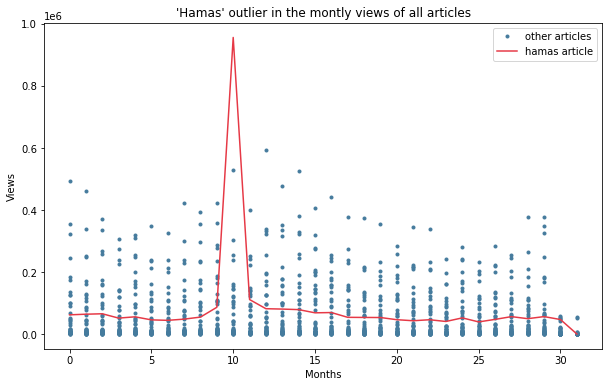

In [39]:
# define some colors
palette=[['#457B9D'], ['#E63946']]

# plot
outlier = 'hamas'
fig = plt.figure(figsize=(10, 6))

for i, (article_name, df_article) in enumerate(gb_articles):
    if not i:
        views_month = df_article.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()
        plt.plot(views_month.index, views_month.views, '.', color='#457B9D', label='other articles')
    elif article_name != outlier:
        views_month = df_article.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()
        plt.plot(views_month.index, views_month.views, '.', color='#457B9D')

# get hamas group and plot it differently
df_article = gb_articles.get_group(outlier)
views_month = df_article.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()
plt.plot(views_month.index, views_month.views, color='#E63946', label='hamas article')

# set legend, axis labels and title
plt.legend(loc="upper right")
plt.xlabel('Months')
plt.ylabel('Views')
plt.title("'Hamas' outlier in the montly views of all articles")
plt.show()

The figure above clearly shows thae presence of an outlier in the provided data. We want to get rid of this outlier as the authors of the paper did. The explanation given in the paper is that the war and conflicts in the Midlle East caused an extreme increase of the views on the 'hamas' article. We will remove this article from our study dataset. But we will show the impact on the monthly views with and without the 'hamas' article.

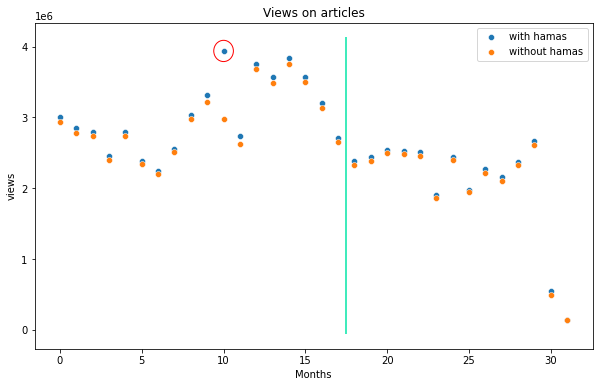

In [40]:
from matplotlib.patches import Ellipse

# set figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

# sum all articles over months
all_views_month = article_views.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()

sns.scatterplot(x=all_views_month.index, y='views', data=all_views_month, ax=ax)

# drop hamas
article_views_clean = article_views[article_views.article != 'hamas']
all_views_month_clean = article_views_clean.groupby(pd.Grouper(key='date', freq='MS')).sum().reset_index()

sns.scatterplot(x=all_views_month_clean.index, y='views', data=all_views_month_clean, ax=ax)

# vertical line to separate before and after June 2013
lims = ax.get_ylim()
plt.vlines(x=17.5, ymin=min(lims), ymax=max(lims), color='#01e5a7')

# plot a circle around the outlier
outlier_x = 10
outlier_point = Ellipse((outlier_x, all_views_month.iloc[outlier_x].views), 1.2, 0.3e6, color='r', fill=False)
ax.add_artist(outlier_point)

# set the legend and title 
ax.legend(['with hamas', 'without hamas'])
ax.set_title('Views on articles')
ax.set(xlabel='Months')

plt.show()

And the figure shows that the general trend in data isn't changed by the removal of the 'hamas' data since the points only shift down by approximately the same amount.

### Regression

We will now be computing the regressions on both periodes in this section. We will use `LinearRegression` model from scikit-learn.

In [152]:
from sklearn.linear_model import LinearRegression
import numpy as np

def plot_replication(df, mid=17, idx_max=32, offs=1):
    """
    :param df: datafram with the data
    :param mid: separating value to use
    :param idx_max: maximum index to use
    :param offs: offset the values on the ploting axis
    :return: tuple with the slopes of the reg models and the prediction for the mid point
    """
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot()

    reg_before = LinearRegression()
    reg_after = LinearRegression()
    before_range = np.arange(mid)
    after_range = np.arange(mid, idx_max)

    reg_before.fit(before_range.reshape(-1,1)+offs, df.iloc[before_range].views)
    reg_pred_before = reg_before.predict(before_range.reshape(-1,1)+offs)

    reg_after.fit(after_range.reshape(-1,1)+offs, df.iloc[after_range].views)
    reg_pred_after = reg_after.predict(after_range.reshape(-1,1)+offs)

    plt.plot(before_range+offs, reg_pred_before, linewidth=3, label="Trend Pre-June 2013", zorder=1)
    plt.plot(after_range+offs, reg_pred_after, linewidth=3, label="Trend Post-June 2013", zorder=1)
    plt.scatter(np.arange(idx_max)+offs, df.iloc[np.arange(idx_max)].views, color='#000000', label="Total article views", zorder=2)

    lims = ax.get_ylim()
    plt.vlines(x=mid-0.5+offs, ymin=min(lims), ymax=max(lims), color='#222222')

    ax.set_xticks(np.arange(0, idx_max+1, 2))
    ax.set_title("Mid June 2013")
    ax.set_xlabel("Time (Months)")
    ax.set_ylabel("Total Views (47 Wikipedia articles, Hamas excluded)")
    plt.legend(loc="lower left", ncol=2, framealpha=1)
    plt.grid(which='major', axis='y')
    plt.show()
    
    return reg_before.coef_, reg_after.coef_, reg_before.predict([[mid]])

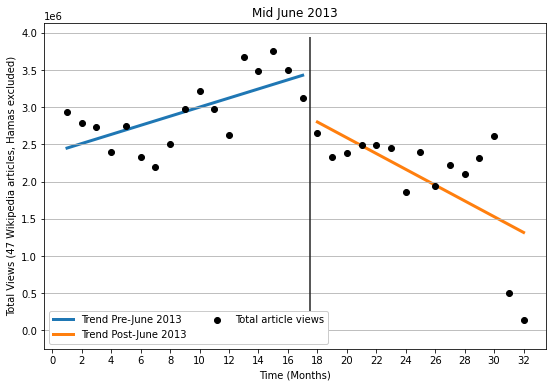

(array([61186.63235294]), array([-106097.23571429]), array([3430827.41176471]))

In [153]:
plot_replication(all_views_month_clean)

We drop the two last months as they are nearly zero and are 

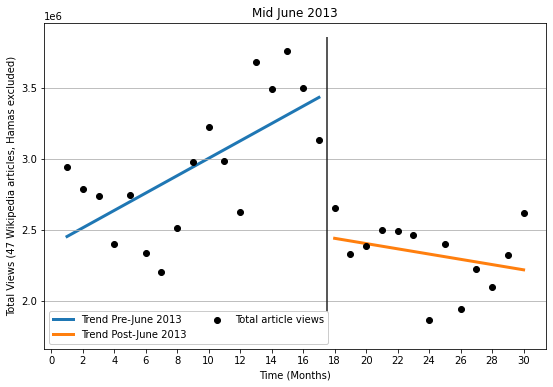

(array([61186.63235294]), array([-18475.62637363]), array([3430827.41176471]))

In [154]:
plot_replication(all_views_month_clean, idx_max=30)

As a reminder and for comparison purposes here is the original figure from the paper

<img src="images/Figure3.png" width=500>